<font color = blue><font size = 6> H(ALF)DLSTM </font></font><br>
DLSTM에서 LSTM을 양쪽(seasonal,trend) 모두에 적용을 해서 안좋은 결과가 나온거 같다고 예상이 돼서 seasonal에만 적용을 한번 해보겠다 또한 여기서는 데이터를 분해하기전에 scaling(multiplication)을 진행했다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [5]:
class Seasonal_Encoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [6]:
class Seasonal_Decoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [7]:
tup= (1,2)
len(tup)

2

In [8]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [9]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [10]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.season_encoder = Seasonal_Encoder(configs)
        self.season_decoder = Seasonal_Decoder(configs)
        
        self.Linear_Trend = nn.Linear(1440,1)
        
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        div_factor = x[:,-1,:].view(-1,1,1)
        x = x/div_factor
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.to(self.device) 

        _,final_season_hidden = self.season_encoder(seasonal_init)
        season_output,_ = self.season_decoder(x = seasonal_init[:,-1,:].view(-1,1,1),encoder_hidden = final_season_hidden)
        trend_output = self.Linear_Trend(trend_init)
        
        output = (trend_output+season_output)*div_factor
        
        return output,season_output,trend_output

In [11]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [12]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_536964/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [14]:
target

tensor([[[22.0614]],

        [[22.0653]],

        [[22.0655]],

        ...,

        [[22.4421]],

        [[22.4284]],

        [[22.4296]]], device='cuda:0')

In [15]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [16]:
torch.manual_seed(42)

In [17]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [18]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#         print(out)
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 21.462918103628994 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 16.540964417270526 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 15.560677768914466 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 14.586136198727884 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 14.385520736115021 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 14.04106287291132 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 15.754169685580926 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 10.234309081151558 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 9.582679977739906 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 9.079078665658102 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 10.701135148856604 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 10.068434515432862 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 9.06974457047079 %
Adju

In [19]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.1629035697078507 %
SMAPE 0.08039646247561905 %
SMAPE 0.07428637515249648 %
SMAPE 0.12970438479987934 %
SMAPE 0.10158360473360517 %
SMAPE 0.08494895221224397 %
SMAPE 0.11923485537863598 %
SMAPE 0.09678038206720885 %
SMAPE 0.12937393764514127 %
SMAPE 0.07535360763881727 %
SMAPE 0.20047558209989802 %
SMAPE 0.10424357627198333 %
SMAPE 0.14496717326892394 %
SMAPE 0.07757817606739081 %
SMAPE 0.04556717582454439 %
SMAPE 0.04541137295018416 %
SMAPE 0.04829616011147664 %
SMAPE 0.08985805244083167 %
SMAPE 0.10359614694243646 %
SMAPE 0.07875532952675712 %
SMAPE 0.10173107010109561 %
SMAPE 0.07408015851615346 %
SMAPE 0.08662497418390558 %
SMAPE 0.1155548217921023 %
SMAPE 0.10519636350181827 %
SMAPE 0.08962238745311879 %
SMAPE 0.1071915061074833 %
SMAPE 0.06207759952394554 %
SMAPE 0.10703300041677723 %
SMAPE 0.08724705560598522 %
SMAPE 0.07356713340141141 %
SMAPE 0.08216165752673987 %
SMAPE 0.07287265450395353 %
SMAPE 0.06565963879438641 %
SMAPE 0.06789589860636625 %
SMAPE 0.095707691023562

SMAPE 0.045299693904780725 %
SMAPE 0.045632829089299776 %
SMAPE 0.045713358602370135 %
SMAPE 0.06124768046953477 %
SMAPE 0.08065983470714855 %
SMAPE 0.11198775300044872 %
SMAPE 0.06539064289427188 %
SMAPE 0.07182297952931549 %
SMAPE 0.08333014236632152 %
SMAPE 0.0741702631703447 %
SMAPE 0.12810311386601825 %
SMAPE 0.12181956195024668 %
SMAPE 0.11407101593431433 %
SMAPE 0.1341816381609533 %
SMAPE 0.08355076715270116 %
SMAPE 0.08577256808121092 %
SMAPE 0.10699061117611564 %
SMAPE 0.08059469103682204 %
SMAPE 0.08251317570102401 %
SMAPE 0.06846811643663386 %
SMAPE 0.10617614896796114 %
SMAPE 0.12149246924673207 %
SMAPE 0.1341885728215857 %
SMAPE 0.13214199079811806 %
SMAPE 0.09574706055127535 %
SMAPE 0.08417328901350629 %
SMAPE 0.0757543049276137 %
SMAPE 0.082017744120094 %
SMAPE 0.08322587430666317 %
SMAPE 0.08808220143873768 %
SMAPE 0.12407650840941642 %
SMAPE 0.09438046218338059 %
SMAPE 0.135186153172981 %
SMAPE 0.0778128658685091 %
SMAPE 0.09949981069212299 %
SMAPE 0.08150297084694103 

SMAPE 0.09786122502237049 %
SMAPE 0.0829020052590721 %
SMAPE 0.06487829682828306 %
SMAPE 0.06879672993272834 %
SMAPE 0.07750286112423055 %
SMAPE 0.1955010254459921 %
SMAPE 0.09534658864799894 %
SMAPE 0.08575272471557582 %
SMAPE 0.09306725159513007 %
SMAPE 0.09567121875625162 %
SMAPE 0.10902203302703128 %
SMAPE 0.15906205873488943 %
SMAPE 0.10998097342599068 %
SMAPE 0.1014689892908791 %
SMAPE 0.09490069374896848 %
SMAPE 0.09725974560569739 %
SMAPE 0.08659502718978729 %
SMAPE 0.19624528991153056 %
SMAPE 0.11015490473391765 %
SMAPE 0.10844122076969143 %
SMAPE 0.09815726602460018 %
SMAPE 0.09619288313933794 %
SMAPE 0.11125163442557094 %
SMAPE 0.12067421172469041 %
SMAPE 0.05409274431144694 %
SMAPE 0.1076532448605576 %
SMAPE 0.0524958307732959 %
SMAPE 0.1017734851895682 %
SMAPE 0.12475608188651677 %
SMAPE 0.1098080785197908 %
SMAPE 0.0814214759884635 %
SMAPE 0.07444881516948954 %
SMAPE 0.08086198949604295 %
SMAPE 0.08742310212437587 %
SMAPE 0.111674112993569 %
SMAPE 0.09898809290439205 %
SM

SMAPE 0.10921731603775699 %
SMAPE 0.06405759638073505 %
SMAPE 0.06359012990287738 %
SMAPE 0.06340280170525148 %
SMAPE 0.07240877623462438 %
SMAPE 0.07703388091067609 %
SMAPE 0.06739882749661774 %
SMAPE 0.06179293748982673 %
SMAPE 0.10907635703006235 %
SMAPE 0.11115068237677406 %
SMAPE 0.15787719538639067 %
SMAPE 0.0777600273193002 %
SMAPE 0.09623465277672949 %
SMAPE 0.10882159044922446 %
SMAPE 0.07375920290178328 %
SMAPE 0.07397126364503492 %
SMAPE 0.07988886803286732 %
SMAPE 0.07123600657405404 %
SMAPE 0.06506029028423654 %
SMAPE 0.10300520109331045 %
SMAPE 0.08461092549350724 %
SMAPE 0.05654108344310771 %
SMAPE 0.044291517606325215 %
SMAPE 0.044131292385543475 %
SMAPE 0.044143339848233154 %
SMAPE 0.09722180819517234 %
SMAPE 0.13312159493034414 %
SMAPE 0.070222581728558 %
SMAPE 0.08084443581174128 %
SMAPE 0.0806818220007699 %
SMAPE 0.06692853798523402 %
SMAPE 0.10752179281280404 %
SMAPE 0.12626323777953985 %
SMAPE 0.08656355529274151 %
SMAPE 0.12364951071197083 %
SMAPE 0.0873969328885

SMAPE 0.07931496325363696 %
SMAPE 0.12649271241025417 %
SMAPE 0.10880583511971052 %
SMAPE 0.11368268456590158 %
SMAPE 0.07843993663050242 %
SMAPE 0.09272368600795744 %
SMAPE 0.1041350616415002 %
SMAPE 0.07501993544747165 %
SMAPE 0.06439205273056814 %
SMAPE 0.06843607078144487 %
SMAPE 0.08099495894566644 %
SMAPE 0.10994329962022677 %
SMAPE 0.09262376663809846 %
SMAPE 0.12022454063026089 %
SMAPE 0.10084593511101048 %
SMAPE 0.04391583252458986 %
SMAPE 0.04446391903911717 %
SMAPE 0.10452491704847942 %
SMAPE 0.10530045216819417 %
SMAPE 0.09043249070077763 %
SMAPE 0.0721104329118134 %
SMAPE 0.08182949643378379 %
SMAPE 0.0839509466088657 %
SMAPE 0.102203546209239 %
SMAPE 0.09865421390810525 %
SMAPE 0.1310859591321787 %
SMAPE 0.10184049651547868 %
SMAPE 0.12399052630871665 %
SMAPE 0.06608686433537514 %
SMAPE 0.02219622221082318 %
SMAPE 0.039407872236211006 %
SMAPE 0.06641757016619465 %
SMAPE 0.11087925657420783 %
SMAPE 0.11353926809761106 %
SMAPE 0.08029002142247066 %
SMAPE 0.11025788753204324

SMAPE 0.10722519302009915 %
SMAPE 0.07806619540770043 %
SMAPE 0.06670377004866168 %
SMAPE 0.10400063520955881 %
SMAPE 0.07902330978845384 %
SMAPE 0.08814676836061608 %
SMAPE 0.12298205609840808 %
SMAPE 0.10231795083564066 %
SMAPE 0.05384896796496719 %
SMAPE 0.12209465196019664 %
SMAPE 0.06783112070661446 %
SMAPE 0.0778660858773037 %
SMAPE 0.07745064317032302 %
SMAPE 0.06802300574963738 %
SMAPE 0.06441674569828137 %
SMAPE 0.11317823044191755 %
SMAPE 0.09726005308402819 %
SMAPE 0.048500523902475834 %
SMAPE 0.04521646667853929 %
SMAPE 0.0625555838623768 %
SMAPE 0.09286975818471888 %
SMAPE 0.0855968348987517 %
SMAPE 0.06716114711161936 %
SMAPE 0.09598669306615193 %
SMAPE 0.07447629912439879 %
SMAPE 0.07823356315020646 %
SMAPE 0.06640625222735252 %
SMAPE 0.10026831181050966 %
SMAPE 0.11186362712487607 %
SMAPE 0.10742100488641883 %
SMAPE 0.062072854688722146 %
SMAPE 0.11030325860338054 %
SMAPE 0.1346670512612036 %
SMAPE 0.07798310131420294 %
SMAPE 0.08316951245069504 %
SMAPE 0.07816107673897

SMAPE 0.10841336437715655 %
SMAPE 0.0954303644657557 %
SMAPE 0.0650889158132486 %
SMAPE 0.1215936177304684 %
SMAPE 0.09606360695761396 %
SMAPE 0.09822879953107133 %
SMAPE 0.11153159330569906 %
SMAPE 0.09324793097675865 %
SMAPE 0.07763346429055673 %
SMAPE 0.08287689614007832 %
SMAPE 0.07309569564586127 %
SMAPE 0.06838759820584528 %
SMAPE 0.09977868345185925 %
SMAPE 0.08046428423176621 %
SMAPE 0.1213528654197944 %
SMAPE 0.1286590626823454 %
SMAPE 0.0896883247214646 %
SMAPE 0.10467161194219445 %
SMAPE 0.07216917348887364 %
SMAPE 0.08363435888168169 %
SMAPE 0.0783629078150625 %
SMAPE 0.022893494860909414 %
SMAPE 0.06645387317530549 %
SMAPE 0.06596173596955168 %
SMAPE 0.11267864692490548 %
SMAPE 0.11547629149478668 %
SMAPE 0.13438372194650583 %
SMAPE 0.09497396900542299 %
SMAPE 0.09977919873017528 %
SMAPE 0.08706762575718585 %
SMAPE 0.13409868751296017 %
SMAPE 0.08921863997966284 %
SMAPE 0.0650876103804876 %
SMAPE 0.10017375160714438 %
SMAPE 0.12589780230518954 %
SMAPE 0.11302221933510737 %

SMAPE 0.12443149463706506 %
SMAPE 0.11920005081992713 %
SMAPE 0.09152738927002702 %
SMAPE 0.06040834985287802 %
SMAPE 0.11766781312508101 %
SMAPE 0.12843105828642365 %
SMAPE 0.11377062322571872 %
SMAPE 0.0696275186882076 %
SMAPE 0.0808957746339729 %
SMAPE 0.08684541963998527 %
SMAPE 0.10330773340137968 %
SMAPE 0.09208183533337433 %
SMAPE 0.09818141673849823 %
SMAPE 0.058936321681358095 %
SMAPE 0.044753276714914136 %
SMAPE 0.04475176521737012 %
SMAPE 0.04444948722175468 %
SMAPE 0.10082151349615742 %
SMAPE 0.08063597733848837 %
SMAPE 0.10725553088695962 %
SMAPE 0.07702637882994168 %
SMAPE 0.08136051248493459 %
SMAPE 0.08146118323361407 %
SMAPE 0.07773602241979916 %
SMAPE 0.10843655450025835 %
SMAPE 0.11093465930935052 %
SMAPE 0.08187789707790216 %
SMAPE 0.134292826467572 %
SMAPE 0.08339735721210673 %
SMAPE 0.11072493623350964 %
SMAPE 0.07498267282642246 %
SMAPE 0.09710838467276517 %
SMAPE 0.08169709075446008 %
SMAPE 0.07702250421789358 %
SMAPE 0.06955374211065646 %
SMAPE 0.10332212296179

SMAPE 0.19566241877691937 %
SMAPE 0.12206083911951282 %
SMAPE 0.12640581803407258 %
SMAPE 0.10222965787488646 %
SMAPE 0.1321076465101214 %
SMAPE 0.08455976833829482 %
SMAPE 0.08642833794237959 %
SMAPE 0.12244721170586104 %
SMAPE 0.10595784954421106 %
SMAPE 0.07746296382902074 %
SMAPE 0.07680794106272515 %
SMAPE 0.10583338758516447 %
SMAPE 0.09111072035159395 %
SMAPE 0.09767763594572898 %
SMAPE 0.13187930059211794 %
SMAPE 0.08630302941946866 %
SMAPE 0.09821536098388606 %
SMAPE 0.10609133764410217 %
SMAPE 0.0732071930915481 %
SMAPE 0.0765949849073877 %
SMAPE 0.08026166528270551 %
SMAPE 0.07380521304003196 %
SMAPE 0.08321606455319852 %
SMAPE 0.10820678858272004 %
SMAPE 0.0816265661436546 %
SMAPE 0.1294302819214863 %
SMAPE 0.10598323302474454 %
SMAPE 0.06300497920301495 %
SMAPE 0.09907134328386746 %
SMAPE 0.06483686976116587 %
SMAPE 0.08741620285491081 %
SMAPE 0.07690415482829849 %
SMAPE 0.07395580217962561 %
SMAPE 0.08581157972048459 %
SMAPE 0.1006048756785276 %
SMAPE 0.09502534490798098 

SMAPE 0.08233170601306483 %
SMAPE 0.06801076373403703 %
SMAPE 0.1264568815779512 %
SMAPE 0.11556039046990918 %
SMAPE 0.10214791685666567 %
SMAPE 0.10644574177240429 %
SMAPE 0.12572862471802182 %
SMAPE 0.10200633323620423 %
SMAPE 0.0648884803135843 %
SMAPE 0.06718055871476736 %
SMAPE 0.08181314122339245 %
SMAPE 0.06800258431940165 %
SMAPE 0.09379614400131686 %
SMAPE 0.0986753458637395 %
SMAPE 0.10115656798893723 %
SMAPE 0.05011082350893048 %
SMAPE 0.045285022250027396 %
SMAPE 0.04448670660667631 %
SMAPE 0.07187806700188304 %
SMAPE 0.10581142008985012 %
SMAPE 0.10808354828986923 %
SMAPE 0.07737452843730352 %
SMAPE 0.07631047797235624 %
SMAPE 0.07669120858190581 %
SMAPE 0.08744082410521514 %
SMAPE 0.10145857681527559 %
SMAPE 0.10956198176882026 %
SMAPE 0.1271395680050773 %
SMAPE 0.08193229728544793 %
SMAPE 0.1220951140330726 %
SMAPE 0.062376959173889183 %
SMAPE 0.0747588770937 %
SMAPE 0.08054499544414284 %
SMAPE 0.0666452476161794 %
SMAPE 0.0945150612674297 %
SMAPE 0.09764138919308607 %
S

SMAPE 0.06707088733810451 %
SMAPE 0.11240405926491803 %
SMAPE 0.0870667033391328 %
SMAPE 0.08268216597366518 %
SMAPE 0.04500841171531533 %
SMAPE 0.045785481173197695 %
SMAPE 0.1056659238552129 %
SMAPE 0.111389606170178 %
SMAPE 0.06925828642943088 %
SMAPE 0.06682542478438336 %
SMAPE 0.07258508895756677 %
SMAPE 0.07729193065824802 %
SMAPE 0.08230907216784544 %
SMAPE 0.08839876698857552 %
SMAPE 0.10101378043327713 %
SMAPE 0.04512880720415069 %
SMAPE 0.04535372799728066 %
SMAPE 0.050122903974170185 %
SMAPE 0.11665575439837994 %
SMAPE 0.09315576440349105 %
SMAPE 0.09309384052721725 %
SMAPE 0.10834067278346993 %
SMAPE 0.07028418802565284 %
SMAPE 0.06725559660253566 %
SMAPE 0.06846839258469117 %
SMAPE 0.09616216979338787 %
SMAPE 0.0453721646986196 %
SMAPE 0.044761174567611306 %
SMAPE 0.09494018395798776 %
SMAPE 0.10595199625640817 %
SMAPE 0.13589250894574434 %
SMAPE 0.07853590453669312 %
SMAPE 0.0817006242396019 %
SMAPE 0.06740747665924118 %
SMAPE 0.09599724523923214 %
SMAPE 0.082996036683653

SMAPE 0.1883668738414599 %
SMAPE 0.0720222202653531 %
SMAPE 0.06905318796520987 %
SMAPE 0.0660942888171121 %
SMAPE 0.06671847129882735 %
SMAPE 0.09481288852839498 %
SMAPE 0.10898830087535316 %
SMAPE 0.12110387458187687 %
SMAPE 0.10755518777295946 %
SMAPE 0.08976066100893831 %
SMAPE 0.0815954234549281 %
SMAPE 0.08569597121277184 %
SMAPE 0.10281220669708091 %
SMAPE 0.08268738988408586 %
SMAPE 0.10781427634310603 %
SMAPE 0.08612523260126181 %
SMAPE 0.09932200776620448 %
SMAPE 0.12702539860038087 %
SMAPE 0.0826457948087409 %
SMAPE 0.10297116915126026 %
SMAPE 0.09107062159955603 %
SMAPE 0.1039670787031355 %
SMAPE 0.06466049656592077 %
SMAPE 0.07106189128899132 %
SMAPE 0.08793173643607588 %
SMAPE 0.08718393611434294 %
SMAPE 0.07921805608202703 %
SMAPE 0.07795614528367878 %
SMAPE 0.07721552169186907 %
SMAPE 0.09232912071138344 %
SMAPE 0.10353629799965346 %
SMAPE 0.10737082012019528 %
SMAPE 0.04577587267885974 %
SMAPE 0.04532771307276562 %
SMAPE 0.045298925004317425 %
SMAPE 0.04530301601334940

SMAPE 0.0854399613044734 %
SMAPE 0.06552077223386732 %
SMAPE 0.07673640398297721 %
SMAPE 0.08055527501710458 %
SMAPE 0.12542443056787533 %
SMAPE 0.09355474300900823 %
SMAPE 0.0864879607041189 %
SMAPE 0.11992918677424314 %
SMAPE 0.07368681541811384 %
SMAPE 0.062042697050799234 %
SMAPE 0.09166780379359807 %
SMAPE 0.12486883608835342 %
SMAPE 0.07948027733073104 %
SMAPE 0.08029051664925646 %
SMAPE 0.07370878752044518 %
SMAPE 0.06801157272366254 %
SMAPE 0.06726001388960867 %
SMAPE 0.10142365883211824 %
SMAPE 0.08718794480000724 %
SMAPE 0.10903317985594187 %
SMAPE 0.09083935918715724 %
SMAPE 0.11111031695054407 %
SMAPE 0.1311251524475665 %
SMAPE 0.12120450671659455 %
SMAPE 0.06608994462700934 %
SMAPE 0.07678329388545535 %
SMAPE 0.0768709107860559 %
SMAPE 0.08051544272166211 %
SMAPE 0.0694701604773229 %
SMAPE 0.06436528925951279 %
SMAPE 0.07903992494311751 %
SMAPE 0.13882215607827675 %
SMAPE 0.09310421251120715 %
SMAPE 0.11334514675581885 %
SMAPE 0.13069750962313265 %
SMAPE 0.0870545647474045

SMAPE 0.08953379403307338 %
SMAPE 0.1308274904586142 %
SMAPE 0.09090493437520308 %
SMAPE 0.1358030452638559 %
SMAPE 0.08738574255585263 %
SMAPE 0.07734702902962454 %
SMAPE 0.07410438819715637 %
SMAPE 0.193174095453287 %
SMAPE 0.10819640893078031 %
SMAPE 0.09106645122415102 %
SMAPE 0.044044848275802906 %
SMAPE 0.08331483660458616 %
SMAPE 0.10530342050060425 %
SMAPE 0.05110041363485607 %
SMAPE 0.04414575098780915 %
SMAPE 0.044107137073297054 %
SMAPE 0.046865470372722484 %
SMAPE 0.1004192401628643 %
SMAPE 0.12572943091163324 %
SMAPE 0.08075126117910258 %
SMAPE 0.0649144874241756 %
SMAPE 0.11116212267506852 %
SMAPE 0.08941728543959471 %
SMAPE 0.09477600622858517 %
SMAPE 0.10012022945966237 %
SMAPE 0.1266923201019381 %
SMAPE 0.06866927249939181 %
SMAPE 0.1933932556567015 %
SMAPE 0.14388307796616573 %
SMAPE 0.09015852038191952 %
SMAPE 0.0440248590975898 %
SMAPE 0.0874605722689239 %
SMAPE 0.12380311147688872 %
SMAPE 0.06981314614768053 %
SMAPE 0.08045732721075183 %
SMAPE 0.08097397979872767 %

SMAPE 0.04563277689953793 %
SMAPE 0.044928755138244014 %
SMAPE 0.04491577386397694 %
SMAPE 0.061611344355469555 %
SMAPE 0.09331488821044331 %
SMAPE 0.08414602527682291 %
SMAPE 0.07451096027944004 %
SMAPE 0.08094582479679957 %
SMAPE 0.08658661798926914 %
SMAPE 0.09155455031719839 %
SMAPE 0.08290340594885492 %
SMAPE 0.07942527171508118 %
SMAPE 0.08755702978794488 %
SMAPE 0.13309584188800727 %
SMAPE 0.10160923952844314 %
SMAPE 0.11044227680531549 %
SMAPE 0.10392098884904044 %
SMAPE 0.13282661533776263 %
SMAPE 0.09448991710587507 %
SMAPE 0.11250063995112214 %
SMAPE 0.11190178366814506 %
SMAPE 0.09807609995687017 %
SMAPE 0.10139597423949452 %
SMAPE 0.10697430204504599 %
SMAPE 0.08208792735240422 %
SMAPE 0.13628063022406423 %
SMAPE 0.08969750869846393 %
SMAPE 0.13186862869770266 %
SMAPE 0.07986927516412834 %
SMAPE 0.06277359777050151 %
SMAPE 0.11055246953128517 %
SMAPE 0.08668535725792026 %
SMAPE 0.08179964496230241 %
SMAPE 0.06576446789040347 %
SMAPE 0.06575811322613845 %
SMAPE 0.1105361517

SMAPE 0.09194012729767564 %
SMAPE 0.07590131205643047 %
SMAPE 0.10022623476743318 %
SMAPE 0.07974403839034494 %
SMAPE 0.08515457505473023 %
SMAPE 0.10092194604112592 %
SMAPE 0.07551407796620424 %
SMAPE 0.07444986208543014 %
SMAPE 0.09002045978286333 %
SMAPE 0.09583493742633209 %
SMAPE 0.1343894322182564 %
SMAPE 0.09045213462559332 %
SMAPE 0.07208752168799037 %
SMAPE 0.1352137481576392 %
SMAPE 0.1055007175236824 %
SMAPE 0.13137975790596101 %
SMAPE 0.20167839377973 %
SMAPE 0.20163404375671234 %
SMAPE 0.13912683715716412 %
SMAPE 0.1848472167748696 %
SMAPE 0.11506335965350445 %
SMAPE 0.1257198058956419 %
SMAPE 0.0941484885988757 %
SMAPE 0.1033713949536832 %
SMAPE 0.08928374479296508 %
SMAPE 0.07891944119000982 %
SMAPE 0.07901602226229443 %
SMAPE 0.07000417706581175 %
SMAPE 0.11086245018395856 %
SMAPE 0.10164324430297711 %
SMAPE 0.11242717461118447 %
SMAPE 0.1331418689187558 %
SMAPE 0.1007971541803272 %
SMAPE 0.12524216501742558 %
SMAPE 0.07586855395607017 %
SMAPE 0.08370449487119913 %
SMAP

SMAPE 0.06837097423613159 %
SMAPE 0.06583812263897926 %
SMAPE 0.0850020617726841 %
SMAPE 0.10829046922026463 %
SMAPE 0.04584875067189387 %
SMAPE 0.1362824286115938 %
SMAPE 0.13669128229958005 %
SMAPE 0.11274839282941684 %
SMAPE 0.11033667986157525 %
SMAPE 0.0836065026524011 %
SMAPE 0.1577305314476689 %
SMAPE 0.10144531132209522 %
SMAPE 0.11303369025154096 %
SMAPE 0.04587887955221959 %
SMAPE 0.046002688686712645 %
SMAPE 0.0633909427378967 %
SMAPE 0.09823261166809515 %
SMAPE 0.09984788199699324 %
SMAPE 0.2013656784165505 %
SMAPE 0.10949246764846521 %
SMAPE 0.07695393532867456 %
SMAPE 0.10968049582356798 %
SMAPE 0.10194492421260293 %
SMAPE 0.08458682172567933 %
SMAPE 0.09794993787318163 %
SMAPE 0.04622218364966102 %
SMAPE 0.04552445017907303 %
SMAPE 0.04620570492352272 %
SMAPE 0.13235136313801377 %
SMAPE 0.06488189164531377 %
SMAPE 0.07344478758932382 %
SMAPE 0.09644573037803639 %
SMAPE 0.06463886319806988 %
SMAPE 0.06864621563164519 %
SMAPE 0.08391667471732944 %
SMAPE 0.08680536998917887

SMAPE 0.11115919101348483 %
SMAPE 0.08508691505267052 %
SMAPE 0.07788504788004502 %
SMAPE 0.08211320706323022 %
SMAPE 0.09394782039407801 %
SMAPE 0.11097439779905471 %
SMAPE 0.09093762157613128 %
SMAPE 0.0744008531826239 %
SMAPE 0.07842473940422678 %
SMAPE 0.08289001642697258 %
SMAPE 0.11470978387478682 %
SMAPE 0.13402448246688436 %
SMAPE 0.08228742078063078 %
SMAPE 0.08199759996205103 %
SMAPE 0.1417073074990185 %
SMAPE 0.09349168349399406 %
SMAPE 0.1398549470177386 %
SMAPE 0.14134892202309857 %
SMAPE 0.10574660630658173 %
SMAPE 0.1019833922926523 %
SMAPE 0.08585922687780112 %
SMAPE 0.07686484070563893 %
SMAPE 0.11860865821927291 %
SMAPE 0.13674622140206338 %
SMAPE 0.1604210957984833 %
SMAPE 0.16052747784124222 %
SMAPE 0.08746418336340867 %
SMAPE 0.24648218558286317 %
SMAPE 0.10530549278519173 %
SMAPE 0.142058958992493 %
SMAPE 0.15425226852676133 %
SMAPE 0.09158358592867444 %
SMAPE 0.09713112442295824 %
SMAPE 0.16906975409369807 %
SMAPE 0.10788304977086229 %
SMAPE 0.1329203896202671 %


SMAPE 0.20517786136042562 %
SMAPE 0.1121742428467769 %
SMAPE 0.06362173080333378 %
SMAPE 0.09731416565955442 %
SMAPE 0.07137728070483718 %
SMAPE 0.08208095889131073 %
SMAPE 0.06426135942638211 %
SMAPE 0.06827580669641975 %
SMAPE 0.07735384377247101 %
SMAPE 0.07045852471583203 %
SMAPE 0.10722175479895668 %
SMAPE 0.09422879763405945 %
SMAPE 0.10931831650123058 %
SMAPE 0.12388115881438466 %
SMAPE 0.13256632900447585 %
SMAPE 0.09056424482878356 %
SMAPE 0.11050742824363624 %
SMAPE 0.1156405017736688 %
SMAPE 0.1087806767791335 %
SMAPE 0.07482061633277226 %
SMAPE 0.0837133572424591 %
SMAPE 0.0819904386298731 %
SMAPE 0.07376316305089858 %
SMAPE 0.06731779329197707 %
SMAPE 0.08210321665683296 %
SMAPE 0.09982923347706674 %
SMAPE 0.1457367303846695 %
SMAPE 0.10853565814795728 %
SMAPE 0.09189760021513393 %
SMAPE 0.05341922042816805 %
SMAPE 0.08901855009480641 %
SMAPE 0.1574863427317723 %
SMAPE 0.1587195858337509 %
SMAPE 0.14499867567701585 %
SMAPE 0.11431288244966709 %
SMAPE 0.08844873145022802 %


SMAPE 0.14605162550333262 %
SMAPE 0.10740630994041567 %
SMAPE 0.07843833784045273 %
SMAPE 0.07350764119632913 %
SMAPE 0.07967679871502753 %
SMAPE 0.08918194588022743 %
SMAPE 0.07974973537398 %
SMAPE 0.07487203339587722 %
SMAPE 0.1258358560121451 %
SMAPE 0.08244181747977564 %
SMAPE 0.10846195565591189 %
SMAPE 0.1111976255360787 %
SMAPE 0.10116547261804953 %
SMAPE 0.11391425237115983 %
SMAPE 0.08900034909129317 %
SMAPE 0.09842477768688696 %
SMAPE 0.0977988640715921 %
SMAPE 0.09776361385706878 %
SMAPE 0.04485958259419931 %
SMAPE 0.08569629829798942 %
SMAPE 0.08281562348929583 %
SMAPE 0.07779881047372328 %
SMAPE 0.19769157768496373 %
SMAPE 0.12657136969437488 %
SMAPE 0.12468544301191287 %
SMAPE 0.10552072794598644 %
SMAPE 0.022695080275298096 %
SMAPE 0.022762457250792067 %
SMAPE 0.07713895156666695 %
SMAPE 0.12226843354619632 %
SMAPE 0.11900849989206108 %
SMAPE 0.08553987734194379 %
SMAPE 0.1670766600367415 %
SMAPE 0.11121321784958128 %
SMAPE 0.12951846564283187 %
SMAPE 0.08224193859496154

SMAPE 0.11155426833784077 %
SMAPE 0.13330070746201272 %
SMAPE 0.10171402971718635 %
SMAPE 0.08339158409580705 %
SMAPE 0.065990831106717 %
SMAPE 0.11589095741601341 %
SMAPE 0.09654068572763208 %
SMAPE 0.11097529477774515 %
SMAPE 0.09435632924396486 %
SMAPE 0.04574252820032143 %
SMAPE 0.10704223785160139 %
SMAPE 0.11846679960308393 %
SMAPE 0.08427628076879046 %
SMAPE 0.08885943413974928 %
SMAPE 0.08899962590066934 %
SMAPE 0.07615858926055807 %
SMAPE 0.0993413952019182 %
SMAPE 0.11082438233097493 %
SMAPE 0.10078662131127203 %
SMAPE 0.1130175750699891 %
SMAPE 0.1345068800583249 %
SMAPE 0.08723118464740764 %
SMAPE 0.08308413157101313 %
SMAPE 0.11960261469357647 %
SMAPE 0.06969019468942861 %
SMAPE 0.07622673205651154 %
SMAPE 0.07448073920386378 %
SMAPE 0.12982040647239046 %
SMAPE 0.06533723662278135 %
SMAPE 0.1275637051630838 %
SMAPE 0.11085473580533288 %
SMAPE 0.0460432926483918 %
SMAPE 0.10688897368891048 %
SMAPE 0.07049443510095443 %
SMAPE 0.10323003811663511 %
SMAPE 0.10470294592278151 %

SMAPE 0.19872441344341496 %
SMAPE 0.11696449825149102 %
SMAPE 0.08235903298918856 %
SMAPE 0.12048848269478184 %
SMAPE 0.13430239914305275 %
SMAPE 0.07312689074888112 %
SMAPE 0.10626716155525172 %
SMAPE 0.11221456008570385 %
SMAPE 0.10653494188318292 %
SMAPE 0.022861756588099524 %
SMAPE 0.07275179286261846 %
SMAPE 0.06396137527053725 %
SMAPE 0.14686111258379242 %
SMAPE 0.08703679442282919 %
SMAPE 0.09504288727202947 %
SMAPE 0.12112366460382872 %
SMAPE 0.10076962111678968 %
SMAPE 0.11651404744316098 %
SMAPE 0.10820233736603768 %
SMAPE 0.0663039678358075 %
SMAPE 0.08271159519790672 %
SMAPE 0.13226180218134687 %
SMAPE 0.09641128328621562 %
SMAPE 0.0931411364476844 %
SMAPE 0.13691222414490767 %
SMAPE 0.13416933482221793 %
SMAPE 0.09595426777650573 %
SMAPE 0.06700316383626159 %
SMAPE 0.06712870903902513 %
SMAPE 0.08331557811470702 %
SMAPE 0.07846513404911093 %
SMAPE 0.08226090775860939 %
SMAPE 0.10993169254925306 %
SMAPE 0.11289565817241963 %
SMAPE 0.08010095096756231 %
SMAPE 0.0997958827756

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
len(pred_list)

10080

In [21]:
target=list(target.values.reshape(-1))

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.12893922626972198 %


In [23]:
pred_list

[22.43852996826172,
 22.447954177856445,
 22.407073974609375,
 22.397010803222656,
 22.439495086669922,
 22.4510440826416,
 22.42498207092285,
 22.390888214111328,
 22.41592025756836,
 22.413433074951172,
 22.419551849365234,
 22.49782371520996,
 22.460838317871094,
 22.428119659423828,
 22.42512321472168,
 22.412099838256836,
 22.37201499938965,
 22.40643310546875,
 22.476083755493164,
 22.395854949951172,
 22.40212059020996,
 22.4064884185791,
 22.451419830322266,
 22.394941329956055,
 22.408689498901367,
 22.451364517211914,
 22.410703659057617,
 22.43927764892578,
 22.42723274230957,
 22.42778205871582,
 22.416540145874023,
 22.389585494995117,
 22.406681060791016,
 22.41353416442871,
 22.408811569213867,
 22.38542938232422,
 22.428451538085938,
 22.43846893310547,
 22.408790588378906,
 22.40196418762207,
 22.38463020324707,
 22.378664016723633,
 22.434803009033203,
 22.38826560974121,
 22.436092376708984,
 22.364429473876953,
 22.40601348876953,
 22.414426803588867,
 22.4306869506

In [24]:
len(target)

10080

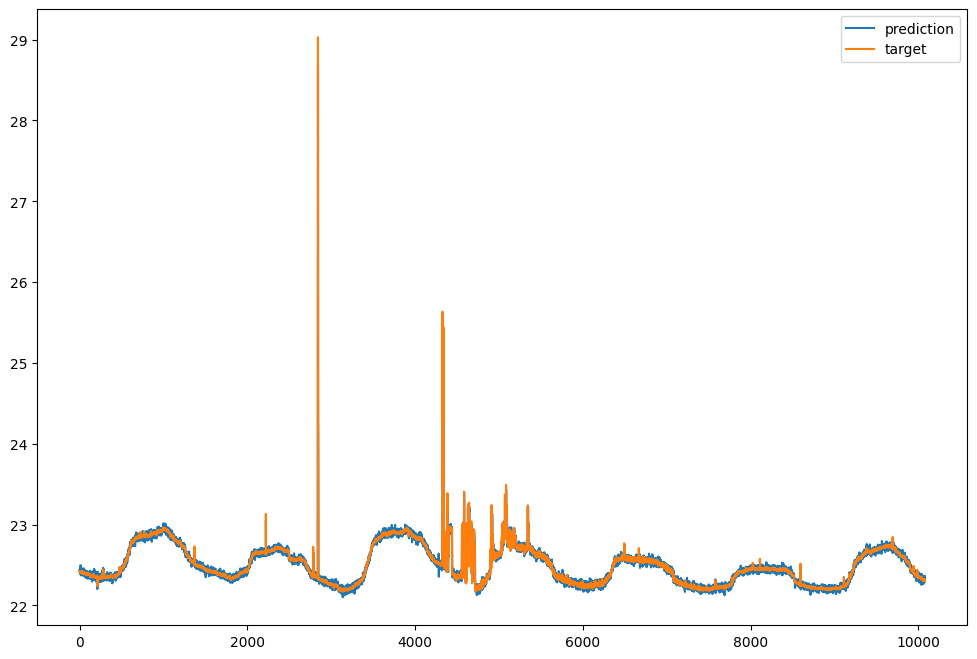

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

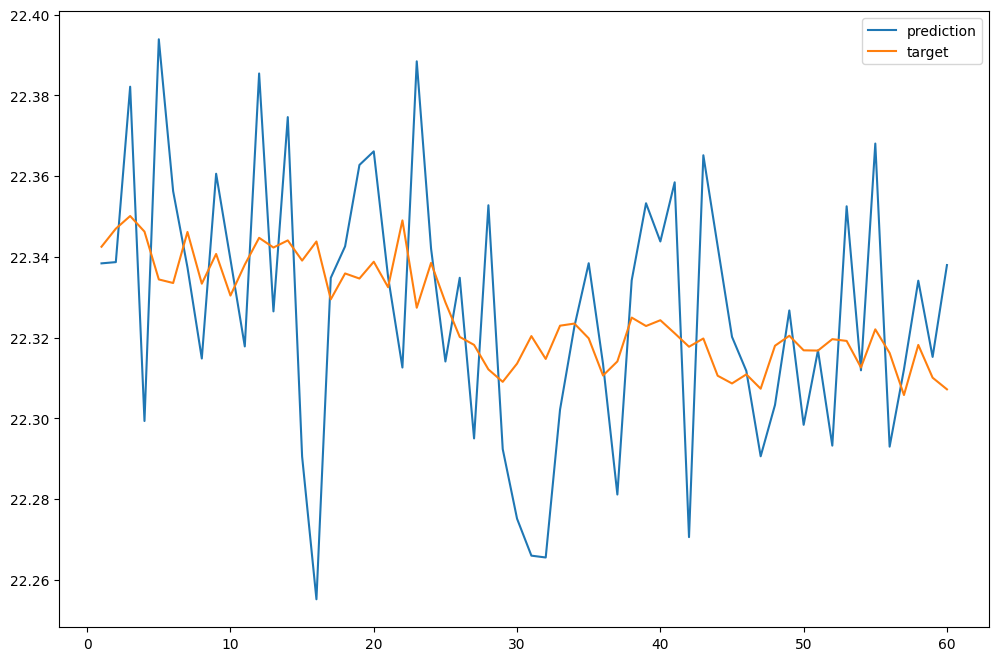

In [26]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [27]:
np.mean(time_list)

0.9150435470162877

1step과 비교했을때level을 맞추면서 sliding을 하게됨

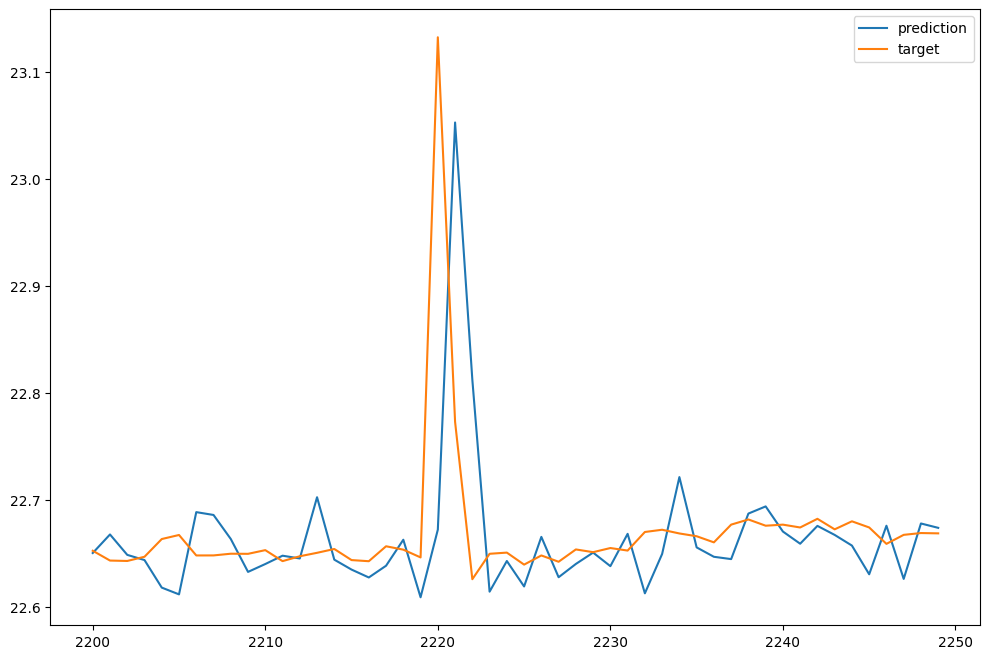

In [28]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()